# **Impacto no uso de People Analytics em decisões organizacionais para identificação de talentos**

**Objetivo:** Este notebook objetiva apresentar os experimentos para a criação de um **Modelo de Classificação**, vinculado ao Trabalho de Conclusão de Curso para Data Science and Analytics, junto a USP-Esalq, utilizando a metodologia CRISP-DM, desde sua fase de Entendimento dos Dados à última etapa de Implantação. 

**Experimentos**: As testagens considerarão o uso de três modelagens: Regressão Logística, Árvore de Decisão e Random Forest. As escolhas destes algoritmos se deram justamente pela complementação entre eles, além da facilidade de uso e interpretabilidade dos modelos. A Regressão Logística é fácil de interpretar e mostra como cada variável impacta a chance de promoção. A Árvore de Decisão gera regras simples e visuais que facilitam entender as decisões. Já o Random Forest é mais robusto, melhorando a precisão e ajudando a evitar erros comuns em modelos mais simples. Desta forma, se torna possível analisar e comparar de forma clara a performance de cada um deles, auxiliando na escolha do modelo "vencedor".

**Link Dataset:** https://www.kaggle.com/datasets/bhrt97/hr-analytics-classification

*Para acessar a documentação do projeto, com os insights, instruções e resultados obtidos, acesse o arquivo README.md deste repositório*

## 📘 Dicionário de Variáveis

| Nome da Variável       | Significado                                                                                           |
|------------------------|-------------------------------------------------------------------------------------------------------|
| **matricula**          | Identificador único do(a) colaborador(a) na empresa.                                                  |
| **departamento**       | Departamento ou área em que o(a) colaborador(a) atua (ex: Vendas, Tecnologia, RH).                   |
| **regiao**             | Região geográfica de atuação do(a) colaborador(a) (sem ordem ou hierarquia específica).               |
| **escolaridade**       | Nível educacional alcançado pelo(a) colaborador(a) (ex: Graduação, Pós-graduação, etc.).             |
| **genero**             | Gênero do(a) colaborador(a), geralmente categorizado como "Masculino" ou "Feminino".                 |
| **canal_recrutamento** | Canal através do qual o(a) colaborador(a) foi recrutado(a) (ex: Recrutamento Interno, Agência).      |
| **qtd_treinamentos**   | Número de treinamentos (técnicos ou comportamentais) realizados no ano anterior.                      |
| **idade**              | Idade do(a) colaborador(a), em anos.                                                                  |
| **avaliacao_anterior** | Nota de desempenho atribuída ao(à) colaborador(a) no ano anterior (geralmente em uma escala de 1 a 5).|
| **tempo_empresa**      | Tempo de serviço na empresa, em anos completos.                                                       |
| **kpis_atingidos**     | Indicador binário: 1 se mais de 80% dos KPIs (indicadores de performance) foram atingidos; 0 caso contrário. |
| **premios**            | Indicador binário: 1 se o(a) colaborador(a) ganhou algum prêmio no ano anterior; 0 caso contrário.    |
| **media_treinamento**  | Nota média obtida nos treinamentos atuais (avaliações de desempenho nos cursos realizados).           |
| **promovido**          | Variável alvo (target): 1 se o(a) colaborador(a) foi recomendado(a) para promoção; 0 caso contrário.  |


## Importar Bibliotecas

In [1]:
# ============================================================
# 1. Importação de bibliotecas para manipulação dos dados e plots 
# ============================================================

import pandas as pd
import numpy as np
from modulo_graficos import grafico_movimentacao_promovidos # Módulo Python (disponível no repositório do projeto)

# ============================================================
# 2. Importação de bibliotecas relacionados à machine learning
# ============================================================

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, recall_score, fbeta_score, confusion_matrix, 
    ConfusionMatrixDisplay, precision_recall_curve, auc
)
import joblib

In [2]:
# ============================================================
# 3. Ajustes visuais para visualização das tabelas e células
# ============================================================

pd.set_option('display.max_colwidth', None) # remover truncamento de valores das colunas
pd.set_option('display.max_rows', None) # remover truncamento do número de linhas exibidas
pd.set_option('display.max_columns', None) # remover truncamento do número de colunas exibidas
pd.set_option('display.float_format', '{:.2f}'.format) # valores quebrados serão setados com 2 casas decimais

## Input dos Dados

A base de dados disponibilizada pelo Kaggle está dividida em dois arquivos: treino e teste. 

Seguirei, portanto, a seguinte abordagem:

- A base de treino será utilizada para treinamento e validação do modelo (usando técnicas como validação cruzada ou divisão em treino/validação).
- A base de teste será utilizada apenas posteriormente para geração das previsões finais, pois seus rótulos são ocultos (avaliação cega).

A abordagem segue desta forma, pois visa garantir que o modelo não tenha acesso a dados do conjunto de teste durante o treinamento, evitando vazamento de informação e garantindo uma avaliação justa.

In [3]:
# ============================================================
# 4. Carregando base de dados e obtendo informações inicial dos dados
# ============================================================

train_df = pd.read_csv("dataset/train_hr_class.csv")
test_df = pd.read_csv("dataset/test_hr_class.csv")
print(f"DF Treino: {train_df.shape}")
print(f"DF Teste: {test_df.shape}")

DF Treino: (54808, 14)
DF Teste: (23490, 13)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [5]:
train_df.head(1)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           23490 non-null  int64  
 1   department            23490 non-null  object 
 2   region                23490 non-null  object 
 3   education             22456 non-null  object 
 4   gender                23490 non-null  object 
 5   recruitment_channel   23490 non-null  object 
 6   no_of_trainings       23490 non-null  int64  
 7   age                   23490 non-null  int64  
 8   previous_year_rating  21678 non-null  float64
 9   length_of_service     23490 non-null  int64  
 10  KPIs_met >80%         23490 non-null  int64  
 11  awards_won?           23490 non-null  int64  
 12  avg_training_score    23490 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 2.3+ MB


In [7]:
test_df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.00,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.00,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.00,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.00,7,0,0,61


## Preparação dos Dados

### Tratamento e Limpeza dos Dados

Nesta seção, realizarei importantes etapas de tratamento de limpeza dos dados, tais como:

- Renomeio de colunas para Português-BR, a fim de facilitar a manipulação e compreensão dos dados
- Verificação de duplicidades
- Analisar o tipo dos dados, para eventuais conversões (caso necessário)
- Verificação de valores nulos e o seu devido tratamento

#### Renomear Variáveis

In [8]:
cols_treino = {"employee_id": "matricula", "department": "departamento", "region": "regiao", "education": "escolaridade",
               "gender": "genero", "recruitment_channel": "canal_recrutamento", "no_of_trainings": "qtd_treinamentos",
               "age": "idade", "previous_year_rating": "avaliacao_anterior", "length_of_service": "tempo_empresa",
               "KPIs_met >80%": "kpis_atingidos", "awards_won?": "premios", "avg_training_score": "media_treinamento",
               "is_promoted": "promovido"}

cols_teste = {"employee_id": "matricula", "department": "departamento", "region": "regiao", "education": "escolaridade",
              "gender": "genero", "recruitment_channel": "canal_recrutamento", "no_of_trainings": "qtd_treinamentos",
              "age": "idade", "previous_year_rating": "avaliacao_anterior", "length_of_service": "tempo_empresa",
              "KPIs_met >80%": "kpis_atingidos", "awards_won?": "premios", "avg_training_score": "media_treinamento"}

train_df = train_df.rename(columns=cols_treino)
test_df = test_df.rename(columns=cols_teste) # subconjunto dos nomes para o DF Teste não tem a variável target (promovido)
train_df.head(1)

,matricula,departamento,regiao,escolaridade,genero,canal_recrutamento,qtd_treinamentos,idade,avaliacao_anterior,tempo_empresa,kpis_atingidos,premios,media_treinamento,promovido
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.00,8,1,0,49,0


In [9]:
X = train_df.drop(["promovido", "matricula"], axis=1)
y = train_df["promovido"]

#### Duplicidade

In [10]:
if train_df['matricula'].duplicated().any():
    print("Existem duplicados")
else:
    print("Não há matrículas duplicadas")

Não há matrículas duplicadas


#### Nulos

In [11]:
train_df.isnull().sum()[train_df.isnull().sum() > 0]

escolaridade          2409
avaliacao_anterior    4124
dtype: int64

In [12]:
print(train_df['matricula'].count())

54808


In [13]:
train_df['escolaridade'].value_counts()

escolaridade
Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: count, dtype: int64

In [14]:
train_df['avaliacao_anterior'].value_counts()

avaliacao_anterior
3.00    18618
5.00    11741
4.00     9877
1.00     6223
2.00     4225
Name: count, dtype: int64

**Para este tratamento de dados, optarei pela imputação de valores fixos:**
- Avaliação Anterior: para quem não teve nota computada para avaliação anterior, igualaremos à zero (0)
- Escolaridade: para quem não tem registro sobre o nível de escolaridade, preencheremos com "No_Education"

In [15]:
# ===============================
# 5. Funções de pré-processamento
# ===============================
def tratar_tipo_dados(df):
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except (ValueError, TypeError):
            pass
        if df[col].dtype == 'object' and df[col].nunique() / len(df) < 0.3: 
            df[col] = df[col].astype('category')
    lista_colunas = ['kpis_atingidos', 'premios', 'promovido']
    for col in lista_colunas:
        if col in df.columns:
            df[col] = df[col].astype('category')
    return df

def tratar_variaveis(df):
    df = df.copy()
    if 'escolaridade' in df.columns:
        if df['escolaridade'].dtype.name == 'category':
            if 'No_Education' not in df['escolaridade'].cat.categories:
                df['escolaridade'] = df['escolaridade'].cat.add_categories(['No_Education'])
        df['escolaridade'] = df['escolaridade'].fillna('No_Education')
    if 'avaliacao_anterior' in df.columns:
        df['avaliacao_anterior'] = df['avaliacao_anterior'].fillna(0)
    return df

tratamento_type = FunctionTransformer(tratar_tipo_dados)
tratamento_custom = FunctionTransformer(tratar_variaveis)

In [16]:
# ===============================
# 6. Pipelines de numérico e categórico
# ===============================
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Identificação dinâmica das colunas após tratamento
def get_feature_types(df):
    df_tmp = tratar_tipo_dados(df.copy())
    num_features = df_tmp.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = df_tmp.select_dtypes(include=['object', 'category']).columns.tolist()
    return num_features, cat_features

num_features, cat_features = get_feature_types(X)

preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

In [17]:
# ===============================
# 7. Pipeline final
# ===============================
pipeline_base = Pipeline(steps=[
    ("tratamento_type", tratamento_type),
    ("tratamento_custom", tratamento_custom),
    ("preprocessor", preprocessor)
])

In [18]:
# ===============================
# 8. Função de avaliação
# ===============================
def print_score(real, pred, proba):
    recall = recall_score(real, pred)
    precision_curve, recall_curve, _ = precision_recall_curve(real, proba)
    aucpr = auc(recall_curve, precision_curve)
    f2 = fbeta_score(real, pred, beta=2)
    print(f"Recall: {recall:.4f}")
    print(f"AUCPR: {aucpr:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print("\nRelatório completo:\n", classification_report(real, pred))
    cm = confusion_matrix(real, pred)
    ConfusionMatrixDisplay(cm, display_labels=['não-promovido','promovido']).plot()

In [19]:
# ===============================
# 9. Modelos
# ===============================
modelos = {
    "Regressão Logística": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced")
}

In [20]:
# ===============================
# 10. Testagem do modelo utilizando Cross-Validation
# ===============================

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "recall": "recall",
    "precision": "precision",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

for nome, modelo in modelos.items():
    pipeline = Pipeline(steps=[
        ("tratamento_type", tratamento_type),
        ("tratamento_custom", tratamento_custom),
        ("preprocessor", preprocessor),
        ("model", modelo)
    ])
    
    resultados = cross_validate(
        pipeline,
        X_val,  
        y_val,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    
    print(f"\n=== {nome} (Validação Cruzada) ===")
    for metrica in scoring.keys():
        media = resultados[f'test_{metrica}'].mean()
        desvio = resultados[f'test_{metrica}'].std()
        print(f"{metrica}: {media:.4f} ± {desvio:.4f}")


=== Regressão Logística (Validação Cruzada) ===
recall: 0.7944 ± 0.0183
precision: 0.2418 ± 0.0117
f1: 0.3707 ± 0.0153
roc_auc: 0.8711 ± 0.0059

=== Árvore de Decisão (Validação Cruzada) ===
recall: 0.4240 ± 0.0199
precision: 0.3955 ± 0.0200
f1: 0.4085 ± 0.0111
roc_auc: 0.6816 ± 0.0080

=== Random Forest (Validação Cruzada) ===
recall: 0.2067 ± 0.0345
precision: 0.8002 ± 0.0528
f1: 0.3273 ± 0.0462
roc_auc: 0.8758 ± 0.0067



=== Random Forest ===
Recall: 0.8276
AUCPR: 0.4683
F2 Score: 0.5595

Relatório completo:
               precision    recall  f1-score   support

           0       0.98      0.76      0.86     10028
           1       0.24      0.83      0.38       934

    accuracy                           0.77     10962
   macro avg       0.61      0.79      0.62     10962
weighted avg       0.92      0.77      0.82     10962



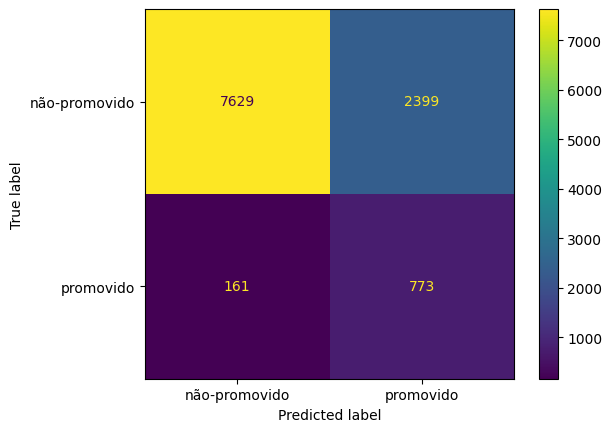

In [21]:
# ===============================
# 11. Treino, validação e avaliação do melhor modelo obtido na seção 10 - CV
# ===============================

best_model = modelos["Regressão Logística"]
pipeline = Pipeline(steps=[
    ("tratamento_type", tratamento_type),
    ("tratamento_custom", tratamento_custom),
    ("preprocessor", preprocessor),
    ("model", best_model)
])
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_val)
probs = pipeline.predict_proba(X_val)[:, 1]
print(f"\n=== {nome} ===")
print_score(y_val, preds, probs)

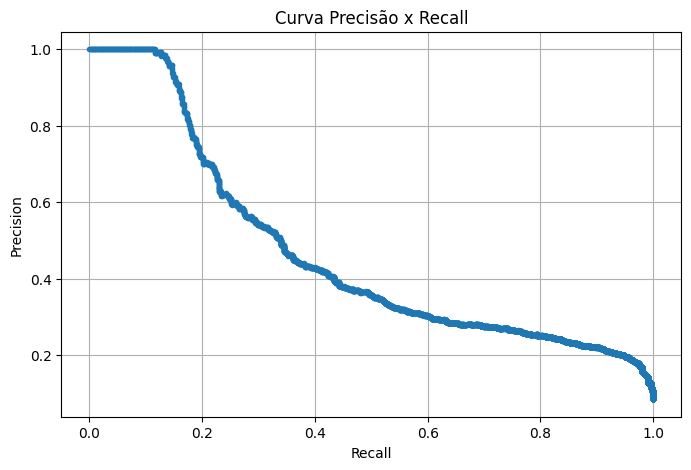

In [27]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_val, probs)

plt.figure(figsize=(8, 5))
plt.plot(recalls, precisions, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precisão x Recall")
plt.grid(True)
plt.show()

In [28]:
from sklearn.metrics import f1_score

melhor_f1 = 0
melhor_threshold = 0.5

for t in thresholds:
    preds_threshold = (probs >= t).astype(int)
    f1 = f1_score(y_val, preds_threshold)
    if f1 > melhor_f1:
        melhor_f1 = f1
        melhor_threshold = t

print(f"Melhor threshold com F1: {melhor_threshold:.2f} | F1: {melhor_f1:.4f}")

Melhor threshold com F1: 0.77 | F1: 0.4211


In [29]:
preds_custom = (probs >= melhor_threshold).astype(int)

Recall: 0.4946
AUCPR: 0.4683
F2 Score: 0.4624

Relatório completo:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94     10028
           1       0.37      0.49      0.42       934

    accuracy                           0.88     10962
   macro avg       0.66      0.71      0.68     10962
weighted avg       0.90      0.88      0.89     10962



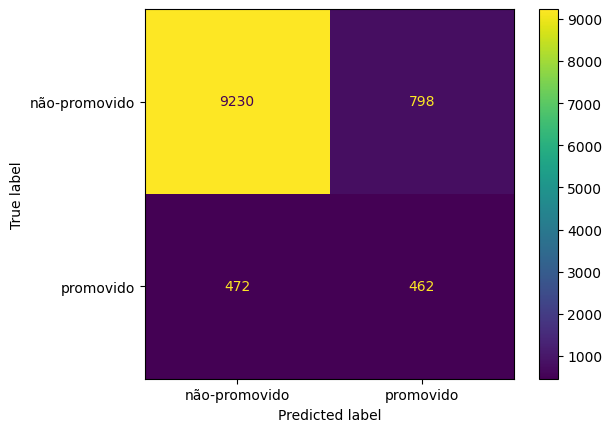

In [30]:
print_score(y_val, preds_custom, probs)

In [22]:
# ===============================
# 12. Aplicação no dataset de teste
# ===============================

final_pipeline = Pipeline(steps=[
    ("tratamento_type", tratamento_type),
    ("tratamento_custom", tratamento_custom),
    ("preprocessor", preprocessor),
    ("model", best_model)
])
final_pipeline.fit(X, y)

preds_test = final_pipeline.predict(test_df)
probs_test = final_pipeline.predict_proba(test_df)[:, 1]

In [23]:
# ===============================
# 13. Salvando modelo e resultados
# ===============================

submission = pd.DataFrame({
    "matricula": test_df["matricula"],
    "promovido": preds_test
})
submission.to_csv("predicoes.csv", index=False)

# Salvar modelo treinado
joblib.dump(final_pipeline, "modelo_final.pkl")

['modelo_final.pkl']